<a href="https://colab.research.google.com/github/baschram/bda-718-group-1/blob/master/Group1_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%%bash
# Need to install pyspark
# if pyspark is already installed, will print a message indicating pyspark already isntalled
pip install pyspark
pip install seaborn

In [4]:
%matplotlib inline
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.ml import feature
import re
from pyspark.sql import functions as fn
from pyspark.sql.functions import col, regexp_replace, split
from pyspark.sql.utils import AnalysisException
from pyspark.sql import Row
from pyspark.sql.types import IntegerType, DateType, FloatType, BooleanType
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

spark = SparkSession \
  .builder \
  .master("local[*]")\
  .config("spark.memory.fraction", 0.8) \
  .config("spark.executor.memory", "12g") \
  .config("spark.driver.memory", "12g")\
  .config("spark.memory.offHeap.enabled",'true')\
  .config("spark.memory.offHeap.size","12g")\
  .getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
sampled_df = spark.read.format("csv").option("header", "true").option('inferSchema','true').load("drive/Shared drives/IST 718 Group1/sampled_used_cars_data_nodesc.csv")


In [4]:
# EDA: Dimension Inspection
print("Number of Observations:",sampled_df.count())
print("Number of Columns:",len(sampled_df.columns))

Number of Observations: 600000
Number of Columns: 64


In [ ]:
sampled_df.describe().show()

+-------+------------+-----+----------+----------+-----------+-----------+-----------+-----------------+--------------------+------------------+------------------+--------------------+-------------------+--------------------+------------------+--------------+-------------+----------------+---------+-------+--------------------+------------------+--------------------+------------+-----------------+------+-----------+-------------+--------------------+------------------+--------------------+--------------------+----------+---------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+--------------------+------------+--------------------+------+------------------+-----------------------+------------+--------------------+---------+-------+------------------+
|summary|back_legroom|  bed|bed_height|bed_length|  body_type|      cabin|       city|city_fuel_economy|comb

In [28]:
# EDA: Duplicate Data Removal
sampled_df = sampled_df.distinct()

# Drop the index column
# Drop exterior color ,power, and wheel system displacement (redundant columns)
# Drop Bed height (no values)
sampled_df = sampled_df.drop(*['power','main_picture_url',
                               'combine_fuel_economy', 'listing_id',
                               'vehicle_damage_category','trimId',
                               'trim_name','exterior_color','wheel_system_display','bed_height','power'])


Dropped addtional columns that contained no or fow entires

In [5]:
# Inspect the drop
print("Number of Observations:",sampled_df.count())
print("Number of Columns:",len(sampled_df.columns))

Number of Observations: 599998
Number of Columns: 54


In [7]:
# EDA: Data Type Inspection
sampled_df.printSchema()

root
 |-- back_legroom: string (nullable = true)
 |-- bed: string (nullable = true)
 |-- bed_length: string (nullable = true)
 |-- body_type: string (nullable = true)
 |-- cabin: string (nullable = true)
 |-- city: string (nullable = true)
 |-- city_fuel_economy: integer (nullable = true)
 |-- daysonmarket: integer (nullable = true)
 |-- dealer_zip: string (nullable = true)
 |-- engine_cylinders: string (nullable = true)
 |-- engine_displacement: integer (nullable = true)
 |-- engine_type: string (nullable = true)
 |-- fleet: boolean (nullable = true)
 |-- frame_damaged: boolean (nullable = true)
 |-- franchise_dealer: boolean (nullable = true)
 |-- franchise_make: string (nullable = true)
 |-- front_legroom: string (nullable = true)
 |-- fuel_tank_volume: string (nullable = true)
 |-- fuel_type: string (nullable = true)
 |-- has_accidents: boolean (nullable = true)
 |-- height: string (nullable = true)
 |-- highway_fuel_economy: integer (nullable = true)
 |-- horsepower: integer (null

In [29]:
# Generate of list of column names for future use
colList = sampled_df.columns
numColList = []
catColList = []

In [30]:
#Needs to occur prior to data type casting as the loop will convert columns back to strings
for x in sampled_df.columns:
  sampled_df = sampled_df.withColumn(x, regexp_replace(col(x),r'--',''))
  sampled_df = sampled_df.withColumn(x, regexp_replace(col(x),r'None',''))

In [31]:
#Column cleaning and type casting

#Function to check if column exists or not
def has_column(df, col):
    try:
        df[col]
        return True
    except AnalysisException:
        return False

sampled_df = sampled_df.withColumn('back_legroom',
                                   regexp_replace(col('back_legroom'),r'\sin',''))
sampled_df = sampled_df.withColumn('front_legroom',
                                   regexp_replace(col('front_legroom'),r'\sin',''))
sampled_df = sampled_df.withColumn('front_legroom',fn.translate('front_legroom','0',''))
sampled_df = sampled_df.withColumn('height',
                                   regexp_replace(col('height'),r'\sin',''))
sampled_df = sampled_df.withColumn('length',
                                   regexp_replace(col('length'),r'\sin',''))
sampled_df = sampled_df.withColumn('wheelbase',
                                   regexp_replace(col('wheelbase'),r'\sin',''))
sampled_df = sampled_df.withColumn('width',
                                   regexp_replace(col('width'),r'\sin',''))
sampled_df = sampled_df.withColumn('bed_length',
                                   regexp_replace(col('bed_length'),r'\sin',''))
sampled_df = sampled_df.withColumn('engine_cylinders',
                                   regexp_replace(col('engine_cylinders'),'[a-zA-Z]',''))
#Remove all digits from engine type
sampled_df = sampled_df.withColumn('engine_type',
                                   regexp_replace(col('engine_type'),r'\d',''))
#Remove all alphabet characters following space
sampled_df = sampled_df.withColumn('engine_type',
                                   regexp_replace(col('engine_type'),r'\s[a-zA-Z]*',''))
sampled_df = sampled_df.withColumn('maximum_seating',
                                   regexp_replace(col('maximum_seating'),r'\sseats',''))
sampled_df = sampled_df.withColumn('fuel_tank_volume',
                                   regexp_replace(col('fuel_tank_volume'),r'\sgal',''))
sampled_df = sampled_df.withColumn('major_options',
                                   regexp_replace(col('major_options'),r"[\[]'",''))
sampled_df = sampled_df.withColumn('major_options',
                                   regexp_replace(col('major_options'),r"'[\]]",''))
sampled_df = sampled_df.withColumn('major_options',
                                   regexp_replace(col('major_options'),r"'",''))
sampled_df = sampled_df.withColumn('transmission_display',
                                   regexp_replace(col('transmission_display'),r"\D*",''))

#Decompose Torque column 
if has_column(sampled_df, 'torque'):
  split_torque = split(sampled_df['torque'],r'\slb-ft\s@')
  sampled_df = sampled_df.withColumn('torque_ftlb',split_torque.getItem(0))
  sampled_df = sampled_df.withColumn('torque_rpm',split_torque.getItem(1))
  #Drop now redundant torque column
  sampled_df = sampled_df.drop('torque')

#Remove all non digit charaters
sampled_df = sampled_df.withColumn('torque_rpm',
                                   regexp_replace(col('torque_rpm'),'\D*',''))
#Calculate new torque grade column
sampled_df = sampled_df.withColumn('torque_grade',
                                   sampled_df.torque_ftlb/sampled_df.torque_rpm)


#Recast column data types


#Integer type loop
integer_cols = ['engine_displacement','engine_cylinders','daysonmarket','horsepower','maximum_seating','mileage','owner_count','savings_amount','transmission_display','year','torque_ftlb','torque_rpm']
for i in integer_cols:
  sampled_df = sampled_df.withColumn(i, sampled_df[i].cast(IntegerType()))

#FloatType loop
float_cols = ['back_legroom','front_legroom','city_fuel_economy','bed_length','fuel_tank_volume','latitude','height','highway_fuel_economy','length','longitude','price','seller_rating','wheelbase','width','torque_grade']
for i in float_cols:
  sampled_df = sampled_df.withColumn(i, sampled_df[i].cast(FloatType()))

#DateType Loop
date_cols = ['listed_date']
for i in date_cols:
  sampled_df = sampled_df.withColumn(i, sampled_df[i].cast(DateType()))

#Boolean Loop
bool_cols = ['fleet','frame_damaged','franchise_dealer','has_accidents','isCab','is_certified','is_cpo','is_new','is_oemcpo','salvage','theft_title']
for i in bool_cols:
  sampled_df = sampled_df.withColumn(i, sampled_df[i].cast(BooleanType()))


Modified some of the regex expressions to clean up the columns

Replaced the individual column recasts to loops so it is easier to see which columns are changed to which type.  It also makes it easier to move columns around and avoid errors

In [26]:
#Verify schema changes
sampled_df.printSchema()

root
 |-- back_legroom: float (nullable = true)
 |-- bed: string (nullable = true)
 |-- bed_length: float (nullable = true)
 |-- body_type: string (nullable = true)
 |-- cabin: string (nullable = true)
 |-- city: string (nullable = true)
 |-- city_fuel_economy: float (nullable = true)
 |-- daysonmarket: integer (nullable = true)
 |-- dealer_zip: string (nullable = true)
 |-- engine_cylinders: integer (nullable = true)
 |-- engine_displacement: integer (nullable = true)
 |-- engine_type: string (nullable = true)
 |-- fleet: boolean (nullable = true)
 |-- frame_damaged: boolean (nullable = true)
 |-- franchise_dealer: boolean (nullable = true)
 |-- franchise_make: string (nullable = true)
 |-- front_legroom: float (nullable = true)
 |-- fuel_tank_volume: float (nullable = true)
 |-- fuel_type: string (nullable = true)
 |-- has_accidents: boolean (nullable = true)
 |-- height: float (nullable = true)
 |-- highway_fuel_economy: float (nullable = true)
 |-- horsepower: integer (nullable = t

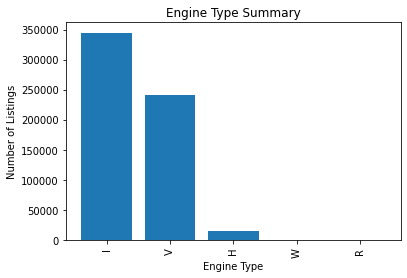

In [34]:
engine_type_count_df = sampled_df.groupBy('engine_type').count().orderBy(fn.desc('count')).dropna().toPandas()

plt.bar(engine_type_count_df['engine_type'],engine_type_count_df['count'])
plt.xticks(rotation='vertical')
plt.xlabel('Engine Type')
plt.ylabel('Number of Listings')
plt.title('Engine Type Summary')
plt.show()

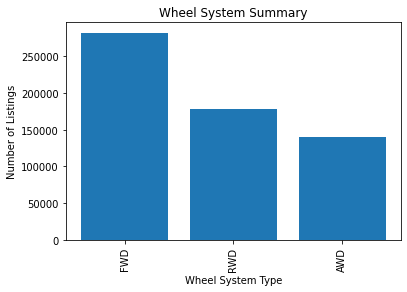

In [23]:
wheel_system_count_df = sampled_df.groupBy('wheel_system').count().orderBy(fn.desc('count')).dropna().toPandas()

plt.bar(wheel_system_count_df['wheel_system'],wheel_system_count_df['count'])
plt.xticks(rotation='vertical')
plt.xlabel('Wheel System Type')
plt.ylabel('Number of Listings')
plt.title('Wheel System Summary')
plt.show()

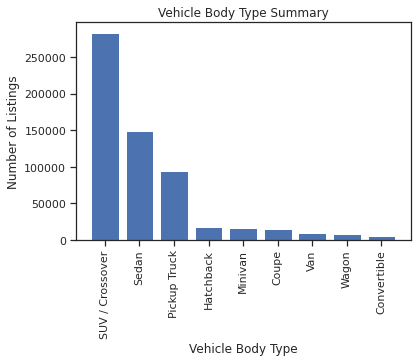

In [77]:
body_count_df = sampled_df.groupBy('body_type').count().orderBy(fn.desc('count')).dropna().toPandas()

plt.bar(body_count_df['body_type'],body_count_df['count'])
plt.xticks(rotation='vertical')
plt.xlabel('Vehicle Body Type')
plt.ylabel('Number of Listings')
plt.title('Vehicle Body Type Summary')
plt.show()

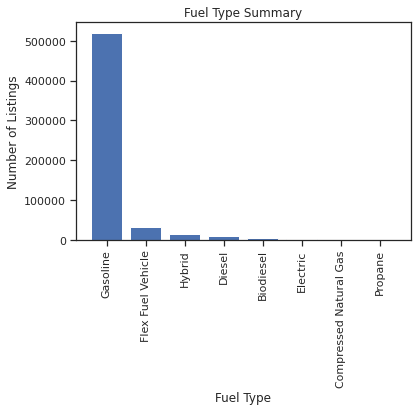

In [79]:
fuel_type_df = sampled_df.groupBy('fuel_type').count().orderBy(fn.desc('count')).dropna().toPandas()

plt.bar(fuel_type_df['fuel_type'],fuel_type_df['count'])
plt.xticks(rotation='vertical')
plt.xlabel('Fuel Type')
plt.ylabel('Number of Listings')
plt.title('Fuel Type Summary')
plt.show()

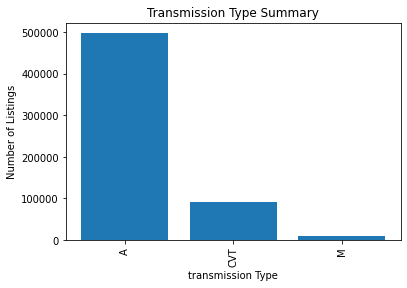

In [22]:
transmission_df = sampled_df.groupBy('transmission').count().orderBy(fn.desc('count')).dropna().toPandas()

plt.bar(transmission_df['transmission'],transmission_df['count'])
plt.xticks(rotation='vertical')
plt.xlabel('transmission Type')
plt.ylabel('Number of Listings')
plt.title('Transmission Type Summary')
plt.show()

In [32]:
#NA Handeling

#Set empty booleans values to false (assume no report = negative condition)
sampled_df = sampled_df.na.fill(False, ['is_cpo','is_new','is_oemcpo','frame_damaged','fleet','isCab','has_accidents','salvage','theft_title'])

sampled_df = sampled_df.na.fill(0, "back_legroom")
sampled_df = sampled_df.na.fill('Gasoline', "fuel_type")
sampled_df = sampled_df.na.fill('SUV / Crossover', "body_type")

sampled_df = sampled_df.na.fill('A', "transmission")
#Consolidate Dual clutch transmissions into automatic category
sampled_df = sampled_df.withColumn('transmission',fn.when(col('transmission') == 'Dual Clutch','A').otherwise(col('transmission')))
    #fn.translate('transmission',"Dual Clutch",'A'))

sampled_df = sampled_df.na.fill('FWD', "wheel_system")
#Consolidate Wheel system type 4x2 in RWD drive category
sampled_df = sampled_df.withColumn('wheel_system',fn.translate('wheel_system',"4X2","RWD"))

#Use Spark imputer transform to replace NAs with median values of specified columns
median_replace_col = ['owner_count','engine_cylinders','engine_displacement','horsepower','maximum_seating','mileage','transmission_display','torque_ftlb','torque_rpm','torque_grade']
na_replace_with_median = feature.Imputer(strategy='median', inputCols=median_replace_col, outputCols=median_replace_col).fit(sampled_df)
sampled_df = na_replace_with_median.transform(sampled_df)

#Use Spark imputer transform to replace NAs with mean values of specified columns
mean_replace_col = ['city_fuel_economy','front_legroom','fuel_tank_volume','highway_fuel_economy','seller_rating','wheelbase','height','length','width']
na_replace_with_mean = feature.Imputer(strategy='mean', inputCols=mean_replace_col, outputCols=mean_replace_col).fit(sampled_df)
sampled_df = na_replace_with_mean.transform(sampled_df)

#Conditional engine type fill if cylinders =6-12 then v type, if < 6 I type
sampled_df = sampled_df.withColumn('engine_type',fn.when(col('engine_cylinders').isin([6,8,10,12]) & fn.isnull(col('engine_type')),'V').otherwise(col('engine_type')))
sampled_df = sampled_df.withColumn('engine_type',fn.when((col('engine_cylinders') < 6) & fn.isnull(col('engine_type')),'I').otherwise(col('engine_type')))
#Any remaining engine_type NAs get filled in with I
sampled_df = sampled_df.na.fill('I', "engine_type")




Set all of the boolean value NAs to false (assume if nothing is reported then the condition is false)

If back leg room was missing assume 0 inches (can this to filter if vehicle has a back seat).  The number of missing entries was pretty low so I don't think it will skew the result too much

For categorical values used the predomiant categorty of the population

Replace integer columns with median

Replace most float columns with mean

Did a conditional replace on engine type to try to better match the options.


In [82]:
sampled_df.describe().show()

+-------+------------------+-----+-----------------+-----------+-----------+-----------+-----------------+------------------+------------------+------------------+-------------------+-----------+--------------+------------------+------------------+---------+-----------------+--------------------+------------------+--------------------+-----------------+------------------+-------------+------------------+--------------------+----------+------------------+------------------+------------------+-----------------+------------------+-----------------+-----------------+------------------+--------------------+------------+--------------------+------------+------------------+-----------------+------------------+------------------+------------------+-------------------+
|summary|      back_legroom|  bed|       bed_length|  body_type|      cabin|       city|city_fuel_economy|      daysonmarket|        dealer_zip|  engine_cylinders|engine_displacement|engine_type|franchise_make|     front_legroom|

In [83]:
sampled_df.select('price','city_fuel_economy','daysonmarket','horsepower','mileage').describe().toPandas()

,summary,price,city_fuel_economy,daysonmarket,horsepower,mileage
0,count,599998,599998,599998,599998,599998
1,mean,29943.769228959765,22.7077597171143,76.10546201820672,247.53597345324485,29859.074530248436
2,stddev,19395.843179159514,8.084578395254297,108.86033738540895,87.8682029283275,44408.063290910424
3,min,165.0,8.0,0,67,0
4,max,2000000.0,127.0,2979,808,1225238


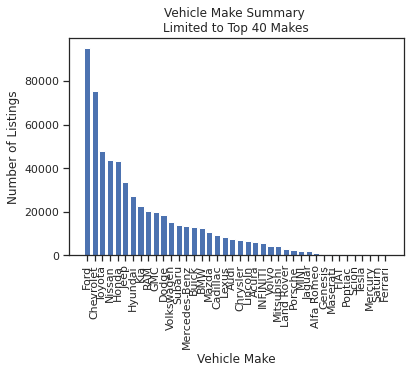

In [84]:
make_count_df = sampled_df.groupBy('make_name').count().orderBy(fn.desc('count')).limit(40).toPandas()

plt.bar(make_count_df['make_name'],make_count_df['count'])
plt.xticks(rotation='vertical')
plt.xlabel('Vehicle Make')
plt.ylabel('Number of Listings')
plt.title('Vehicle Make Summary \nLimited to Top 40 Makes')
plt.show()

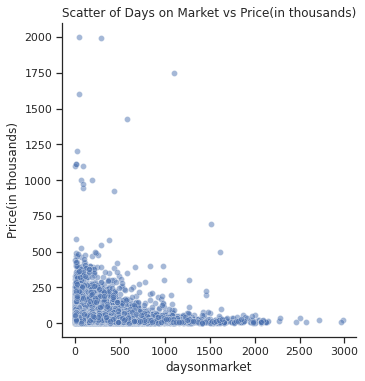

In [35]:

sns.set(style='ticks') # Set style


sampled_df = sampled_df.withColumn("Price(in thousands)", (sampled_df['price'] / 1000))


n1 = sns.relplot(data = sampled_df.toPandas(),
                 x = "daysonmarket",
                 y = "Price(in thousands)",
                 alpha = 0.5) #set plotting parameters

n1.ax.xaxis.grid(True, "minor", linewidth=.25)
n1.ax.yaxis.grid(True, "minor", linewidth=.25)
#sns.plt.ticklabel_format(style = 'plain', axis = "y", useOffset = False)
n1.ax.set_title("Scatter of Days on Market vs Price(in thousands)")
n1.fig.set_size_inches(5,5)
display(n1)

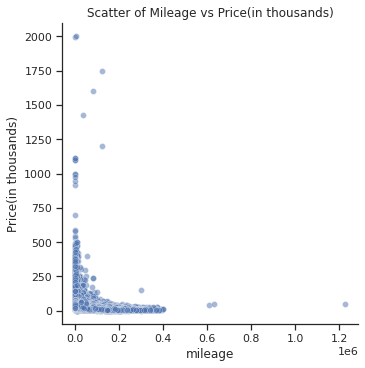

In [36]:
n3 = sns.relplot(data = sampled_df.toPandas(),
                 x = "mileage",
                 y = "Price(in thousands)",
                 alpha = 0.5) #set plotting parameters

n3.ax.xaxis.grid(True, "minor", linewidth=.25)
n3.ax.yaxis.grid(True, "minor", linewidth=.25)
n3.ax.set_title("Scatter of Mileage vs Price(in thousands)")
n3.fig.set_size_inches(5,5)
display(n3)

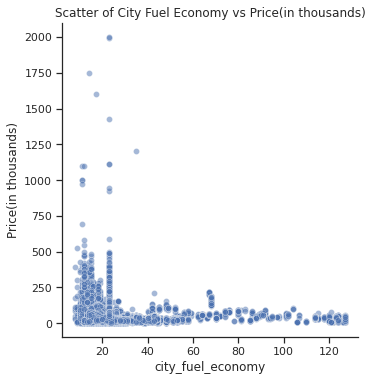

In [37]:
n2 = sns.relplot(data = sampled_df.toPandas(),
                 x = "city_fuel_economy",
                 y = "Price(in thousands)",
                 alpha = 0.5) #set plotting parameters

n2.ax.xaxis.grid(True, "minor", linewidth=.25)
n2.ax.yaxis.grid(True, "minor", linewidth=.25)
n2.ax.set_title("Scatter of City Fuel Economy vs Price(in thousands)")
n2.fig.set_size_inches(5,5)
display(n2)